<a href="https://colab.research.google.com/github/jcdumlao14/Data-Science-Internship-Program-SKS/blob/main/Task_5_Model_Evaluation_and_Interpretation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Task 5: Model Evaluation and Interpretation**
## **Description:**
Evaluate the best predictive model using the testing dataset. Interpret model coefficients or feature importances to comprehend factors influencing churn. Create ROC curves and calculate AUC for model performance assessment.
## **Skills:**
- Model evaluation
- Interpreting coefficients/features importance
- ROC curve analysis
- AUC calculation
- Understanding of model performance metrics


# **Import Libraries**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer  # Import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

## Warnings
import warnings
warnings.filterwarnings('ignore')

# **Load Data:**
- Reads the customer churn dataset from a CSV file into a table-like structure.


In [2]:
# Load the dataset
df = pd.read_csv("Telco_Customer_Churn_Dataset  (3).csv")
df.head().style.background_gradient(cmap='plasma')

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.850000,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.950000,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.850000,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.300000,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.700000,151.65,Yes


In [3]:
df.describe().style.background_gradient(cmap='tab20c')

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


# **Data Cleaning and Preprocessing**

  - Fixes a data type issue in the 'TotalCharges' column, converting values to numbers. If some values can't be converted, they are marked as missing.
  - Fills in the missing values in the numerical columns with the average value of that column.
  - Converts 'Yes'/'No' values in several columns (like 'Partner', 'Churn') to 1s and 0s. This makes it easier for the models to understand.
  - Changes 'Male'/'Female' in the 'gender' column to 1s and 0s.

In [4]:
# Data Cleaning and Preprocessing
# Convert TotalCharges to numeric, handling errors by converting invalid entries to NaN
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Handle missing values (NaN) - replace with the mean
# Use SimpleImputer to fill missing values with the mean

# Preprocessor with Imputation
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])


In [5]:
# Convert binary categorical features to numerical
binary_cols = ['Partner', 'Dependents', 'PhoneService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling', 'Churn']
for col in binary_cols:
    df[col] = df[col].map({'Yes': 1, 'No': 0})

# Convert gender to numerical
df['gender'] = df['gender'].map({'Male': 1, 'Female': 0})

# **Create New Feature (Optional):**
- Groups customers based on how long they've been with the company ('tenure') into categories like '0-12 months', '12-24 months', etc. This can help the model find patterns based on customer tenure.

In [6]:
# Feature Engineering
# Creating a tenure_group feature
def tenure_group(tenure):
    if tenure <= 12:
        return '0-12'
    elif tenure <= 24:
        return '12-24'
    elif tenure <= 48:
        return '24-48'
    elif tenure <= 60:
        return '48-60'
    else:
        return '60+'

df['tenure_group'] = df['tenure'].apply(tenure_group)

In [7]:
# Define features (X) and target (y)
X = df.drop(['customerID', 'Churn'], axis=1)
y = df['Churn']


# **Prepare Data for Modeling:**

- Separates the data into features (the information used to predict churn, like tenure, contract type, etc.) and the target (what we're trying to predict: whether a customer churns or not).
- Identifies which features are numerical (numbers) and which are categorical (categories/text).

In [8]:
# Identify categorical and numerical features
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns


# **Set Up Data Transformation:**

- Creates a "preprocessor" that automatically does these things:
    - For numerical features, it fills missing values with the mean and then scales the data so all features have a similar range of values.
    - For categorical features, it converts them into a format that the models can understand using one-hot encoding. This creates new columns for each category.

In [9]:
# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])


# **Split Data:**
- Splits the data into training and testing sets. The training set is used to teach the model, and the testing set is used to evaluate how well the model has learned. A stratified split ensures that the proportion of churned customers is the same in both the training and testing sets.

In [10]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)  #stratify for balanced split


# **Model Training and Evaluation (Repeated for Each Model):**
- Set up a Pipeline: Creates a sequence of steps. First, it applies the data preprocessing from step 5, and then it trains a specific model (Logistic Regression, Decision Tree, or Random Forest).
- Tune Model Parameters: Uses GridSearchCV to find the best settings (hyperparameters) for each model. It tries out different combinations of settings and uses cross-validation to see which settings give the best performance based on the F1-score.
- Train the Best Model: Trains the model with the best settings found in the previous step.
- Make Predictions: Uses the trained model to predict churn on the testing data. Also, gets the probability of churn for each customer.
- Evaluate Performance: Calculates several metrics to see how well the model is performing:
     - Accuracy: Overall, how many predictions were correct.
     - Precision: Of the customers the model predicted would churn, how many actually did.
     - Recall: Of all the customers who actually churned, how many did the model correctly identify.
     - F1-score: A balance between precision and recall.
     - AUC (Area Under the ROC Curve): Measures how well the model can distinguish between customers who will churn and those who won't.
- Prints the best settings for the model and the performance metrics.

In [11]:
# --- Model 1: Logistic Regression ---
pipeline_lr = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced'))])  # Added class_weight

param_grid_lr = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10]
}

grid_search_lr = GridSearchCV(pipeline_lr, param_grid_lr, cv=5, scoring='f1') # changed scoring to f1
grid_search_lr.fit(X_train, y_train)

best_model_lr = grid_search_lr.best_estimator_
y_pred_lr = best_model_lr.predict(X_test)
y_prob_lr = best_model_lr.predict_proba(X_test)[:, 1] # Probabilities for ROC AUC


# Calculate metrics
accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr)
recall_lr = recall_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)



print("Logistic Regression Results:")
print(f"Best Parameters: {grid_search_lr.best_params_}")
print(f"Accuracy: {accuracy_lr:.4f}")
print(f"Precision: {precision_lr:.4f}")
print(f"Recall: {recall_lr:.4f}")
print(f"F1-score: {f1_lr:.4f}")
print(f"AUC: {roc_auc_lr:.4f}") #Added AUC
print("-" * 30)


Logistic Regression Results:
Best Parameters: {'classifier__C': 0.01}
Accuracy: 0.7360
Precision: 0.5017
Recall: 0.7754
F1-score: 0.6092
AUC: 0.8402
------------------------------


In [12]:
# --- Model 2: Decision Tree ---
pipeline_dt = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', DecisionTreeClassifier(random_state=42, class_weight='balanced'))]) #Added class_weight

param_grid_dt = {
    'classifier__max_depth': [3, 5, 7, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 3, 5]
}

grid_search_dt = GridSearchCV(pipeline_dt, param_grid_dt, cv=5, scoring='f1') # changed scoring to f1
grid_search_dt.fit(X_train, y_train)

best_model_dt = grid_search_dt.best_estimator_
y_pred_dt = best_model_dt.predict(X_test)
y_prob_dt = best_model_dt.predict_proba(X_test)[:, 1]  # Probabilities for ROC AUC


# Calculate metrics
accuracy_dt = accuracy_score(y_test, y_pred_dt)
precision_dt = precision_score(y_test, y_pred_dt)
recall_dt = recall_score(y_test, y_pred_dt)
f1_dt = f1_score(y_test, y_pred_dt)
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_prob_dt)
roc_auc_dt = auc(fpr_dt, tpr_dt)

print("Decision Tree Results:")
print(f"Best Parameters: {grid_search_dt.best_params_}")
print(f"Accuracy: {accuracy_dt:.4f}")
print(f"Precision: {precision_dt:.4f}")
print(f"Recall: {recall_dt:.4f}")
print(f"F1-score: {f1_dt:.4f}")
print(f"AUC: {roc_auc_dt:.4f}") # Added AUC
print("-" * 30)


Decision Tree Results:
Best Parameters: {'classifier__max_depth': 3, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}
Accuracy: 0.7459
Precision: 0.5140
Recall: 0.7834
F1-score: 0.6208
AUC: 0.8144
------------------------------


In [13]:
# --- Model 3: Random Forest ---
pipeline_rf = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))]) # Added class_weight

param_grid_rf = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [5, 10, 15, None],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2]
}

grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=5, scoring='f1')  # changed scoring to f1
grid_search_rf.fit(X_train, y_train)

best_model_rf = grid_search_rf.best_estimator_
y_pred_rf = best_model_rf.predict(X_test)
y_prob_rf = best_model_rf.predict_proba(X_test)[:, 1]  # Probabilities for ROC AUC

# Calculate metrics
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)


print("Random Forest Results:")
print(f"Best Parameters: {grid_search_rf.best_params_}")
print(f"Accuracy: {accuracy_rf:.4f}")
print(f"Precision: {precision_rf:.4f}")
print(f"Recall: {recall_rf:.4f}")
print(f"F1-score: {f1_rf:.4f}")
print(f"AUC: {roc_auc_rf:.4f}") # Added AUC
print("-" * 30)


Random Forest Results:
Best Parameters: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 50}
Accuracy: 0.7608
Precision: 0.5362
Recall: 0.7326
F1-score: 0.6192
AUC: 0.8367
------------------------------


# **Feature Importance (Random Forest Only):**
- If the model is a Random Forest, it identifies which features were most important in making predictions. It then displays this information in a table and a bar chart.


Feature Importances (Random Forest):
                                    Feature  Importance
4                                    tenure    0.113326
14                             TotalCharges    0.098731
13                           MonthlyCharges    0.087882
21                  Contract_Month-to-month    0.078083
9                               TechSupport    0.077480
6                            OnlineSecurity    0.075700
23                        Contract_Two year    0.070087
28                        tenure_group_0-12    0.045050
26           PaymentMethod_Electronic check    0.040132
19              InternetService_Fiber optic    0.037319
7                              OnlineBackup    0.023953
22                        Contract_One year    0.021399
12                         PaperlessBilling    0.019919
18                      InternetService_DSL    0.019176
8                          DeviceProtection    0.016993
20                       InternetService_No    0.015733
0         

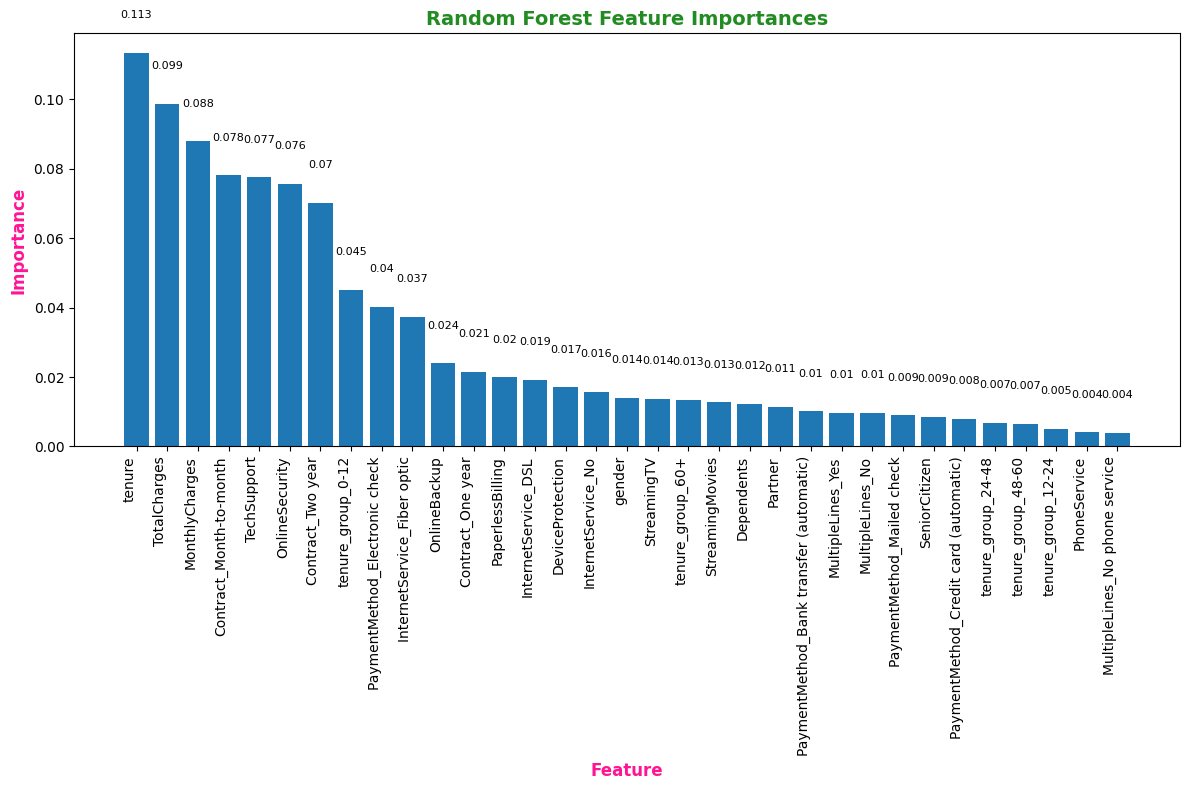

In [14]:
# Feature Importance (Random Forest)

try:
    if hasattr(best_model_rf.named_steps['classifier'], 'feature_importances_'):
        feature_importances = best_model_rf.named_steps['classifier'].feature_importances_

        # Get numerical feature names *before* scaling:
        numerical_feature_names = numerical_features.tolist()

        # Get one-hot encoded categorical feature names:
        categorical_feature_names = best_model_rf.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out().tolist()

        # Combine numerical and categorical feature names
        feature_names = numerical_feature_names + categorical_feature_names

        # Create a dataframe to display feature importances
        feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
        feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)
        print("\nFeature Importances (Random Forest):")
        print(feature_importance_df)


        # Plotting Feature Importances
        plt.figure(figsize=(12, 8))
        plt.bar(feature_importance_df['Feature'], feature_importance_df['Importance'])
        plt.xlabel('Feature',fontsize=12,fontweight = 'bold', color = 'deeppink')
        plt.ylabel('Importance',fontsize=12,fontweight = 'bold', color = 'deeppink')
        plt.title('Random Forest Feature Importances',fontsize=14, fontweight = 'bold', color = 'forestgreen')
        plt.xticks(rotation=90, ha='right', fontsize=10)  # Rotate x-axis labels for readability
        plt.tight_layout()

        # Annotate the bars with their values
        for i, v in enumerate(feature_importance_df['Importance']):
            plt.text(i, v + 0.01, str(round(v, 3)), ha='center', fontsize=8)

        plt.show()

except Exception as e:
    print(f"Could not display feature importances: {e}")


# **Plot Results:**
- Bar Chart: Creates a bar chart comparing the accuracy, precision, recall, F1-score and AUC of all three models.

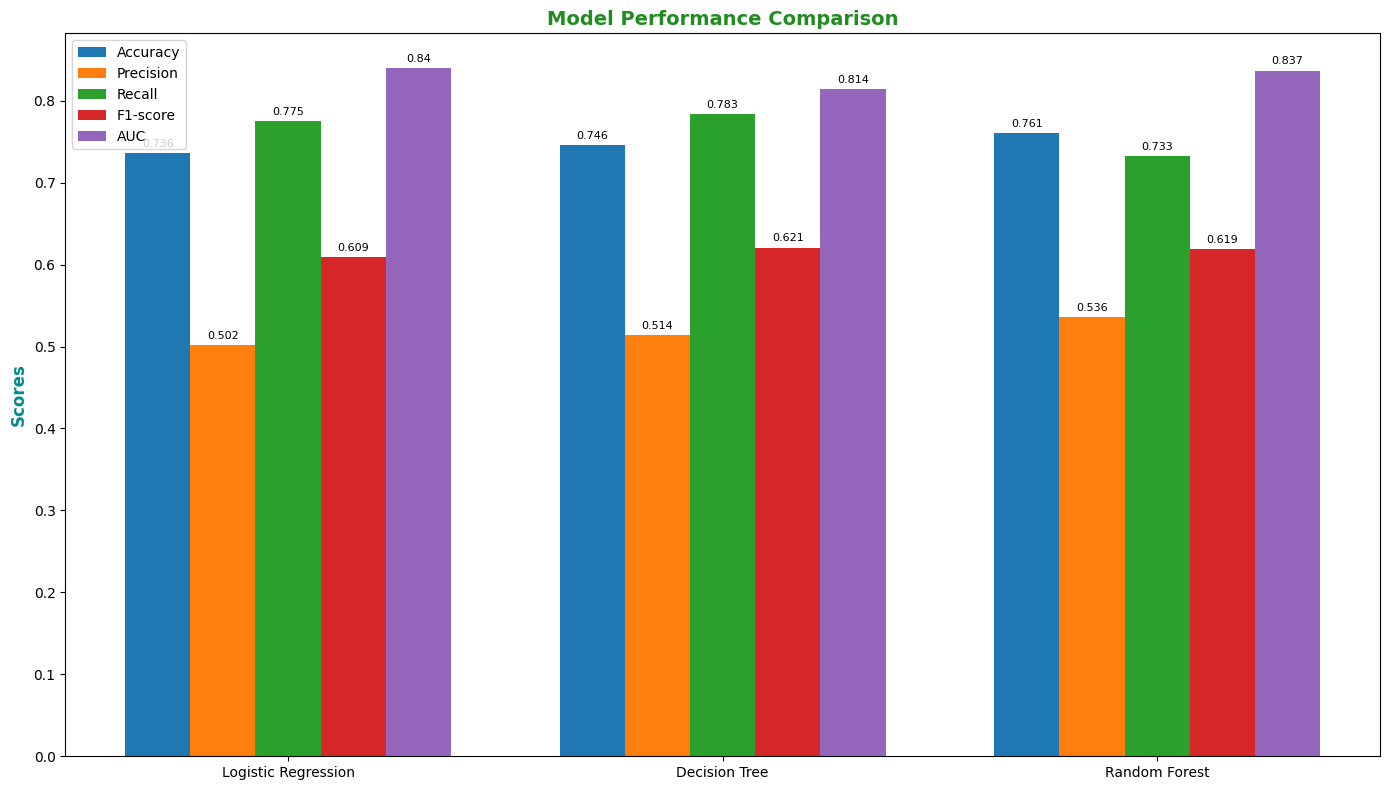

In [16]:
# --- Plotting Model Results ---
model_names = ['Logistic Regression', 'Decision Tree', 'Random Forest']
accuracy_scores = [accuracy_lr, accuracy_dt, accuracy_rf]
precision_scores = [precision_lr, precision_dt, precision_rf]
recall_scores = [recall_lr, recall_dt, recall_rf]
f1_scores = [f1_lr, f1_dt, f1_rf]
auc_scores = [roc_auc_lr, roc_auc_dt, roc_auc_rf] # Added AUC scores

x = np.arange(len(model_names))  # the label locations
width = 0.15  # Reduced width for AUC bar

fig, ax = plt.subplots(figsize=(14, 8))  # Adjusted figure size for better spacing
rects1 = ax.bar(x - 2*width, accuracy_scores, width, label='Accuracy')
rects2 = ax.bar(x - width, precision_scores, width, label='Precision')
rects3 = ax.bar(x, recall_scores, width, label='Recall')
rects4 = ax.bar(x + width, f1_scores, width, label='F1-score')
rects5 = ax.bar(x + 2*width, auc_scores, width, label='AUC')  # Added AUC bar


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores', fontsize=12,fontweight = 'bold', color = 'darkcyan')
ax.set_title('Model Performance Comparison',fontsize=14,fontweight = 'bold', color = 'forestgreen')
ax.set_xticks(x)
ax.set_xticklabels(model_names, fontsize=10)
ax.legend(fontsize=10)

# Function to add labels above the bars
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 3)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)
autolabel(rects5) #Added AUC

fig.tight_layout()
plt.show()

- ROC Curve: Plots the ROC curves for all three models on the same graph to visually compare their ability to distinguish between churners and non-churners.

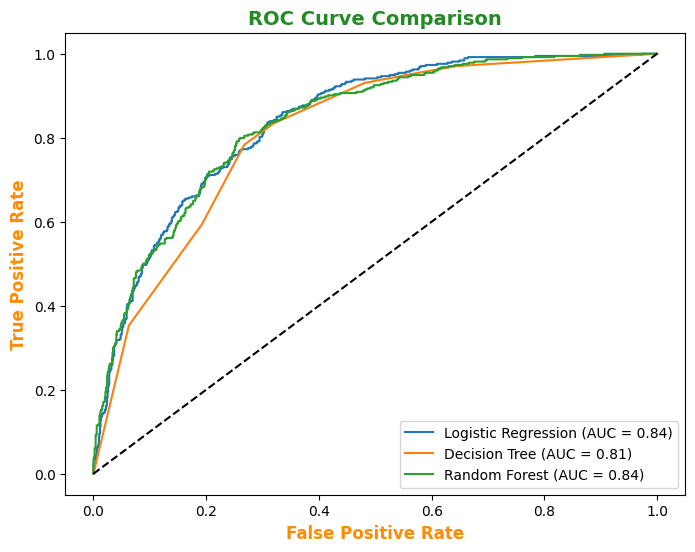

In [17]:
# --- Plotting ROC Curves ---

plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_lr:.2f})')
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {roc_auc_dt:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate',fontsize = 12, fontweight = 'bold', color = 'darkorange')
plt.ylabel('True Positive Rate',fontsize = 12, fontweight = 'bold', color = 'darkorange')
plt.title('ROC Curve Comparison',fontsize=14,fontweight = 'bold', color = 'forestgreen')
plt.legend()
plt.show()

- ROC Curve Analysis:
  - `sklearn.metrics.roc_curve` is used to calculate the True Positive Rate (TPR) and False Positive Rate (FPR) at various threshold settings. This is the data needed to plot the ROC curve.
  - The code generates and displays a plot of the ROC curves for each model (Logistic Regression, Decision Tree, Random Forest) on the same graph, enabling a visual comparison of their performance. This is the analysis portion - seeing how the curves compare to each other and the diagonal (random chance) line.

- AUC Calculation:
  - `sklearn.metrics.auc` is used to calculate the Area Under the ROC Curve (AUC). AUC provides a single scalar value that summarizes the overall performance of the model in distinguishing between the positive and negative classes.
  - The AUC value is printed alongside other performance metrics (accuracy, precision, recall, F1-score) for each model.
  - The AUC value is also included in the legend of the ROC curve plot, providing a quick reference for comparing the models. The model comparison bar plot also includes AUC as a performance metric.

- Understanding of Model Performance Metrics:
  - Accuracy: Overall correctness of the model.
  - Precision: Ability of the model to avoid labeling negative examples as positive.
  - Recall: Ability of the model to find all the positive examples.
  - F1-score: Harmonic mean of precision and recall, balancing both concerns.
  - AUC: The area under the ROC curve, representing the model's ability to distinguish between classes.

